<a href="https://colab.research.google.com/github/mehakjindal1998/covid-19/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow import keras
from numpy import savez_compressed
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import operator

### 1. Load Images

In [106]:
# load all images in a directory into memory
def load_images(path1, path2, size=(128,128)):
    src_list, tar_list = list(), list()
    
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path1):
    # load and resize the image
        pixels = load_img(path1 + filename, target_size=size)
        # convert to numpy array
        dmsp_img = img_to_array(pixels)
        src_list.append(dmsp_img)

    for filename in listdir(path2):
        pixels = load_img(path2 + filename, target_size=size)
        viirs_img = img_to_array(pixels)
        tar_list.append(dmsp_img)
    
    return [asarray(src_list), asarray(tar_list)]

In [107]:
# Load satellites monthly data
path_dmsp ='/content/drive/MyDrive/Sem3/GAN Input/dmsp/'
path_viirs ='/content/drive/MyDrive/Sem3/GAN Input/viirs/'
[dmsp, viirs] = load_images(path_dmsp, path_viirs)

In [108]:
# save as compressed numpy array
filename = 'ntl_128.npz'
savez_compressed(filename, dmsp, viirs)
print('Saved dataset: ', filename)

Saved dataset:  ntl_128.npz


In [109]:
print (dmsp.shape, viirs.shape)

(8, 128, 128, 3) (8, 128, 128, 3)


### 2. Plot random images

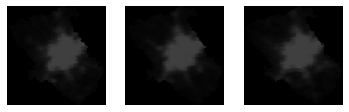

In [110]:
from matplotlib import pyplot
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dmsp[i].astype('uint8'))

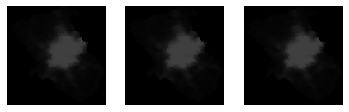

In [111]:
from matplotlib import pyplot
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(viirs[i].astype('uint8'))

In [112]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

### 3. Discrimator

In [113]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(256, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

### 4. Generator

In [114]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 256)
	e5 = define_encoder_block(e4, 256)
	e6 = define_encoder_block(e5, 256)
	# bottleneck, no batch norm and relu
	b = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e6)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e6, 256)
	d2 = decoder_block(d1, e5, 256)
	d3 = decoder_block(d2, e4, 256)
	d4 = decoder_block(d3, e3, 256, dropout=False)
	d5 = decoder_block(d4, e2, 128, dropout=False)
	d6 = decoder_block(d5, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d6)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

### 5. Combine generator and Discriminator 

In [115]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [116]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

### 7. Pick random training samples and label them as real-> Label as 1

In [117]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

### 7. Use generator modela and real images to generate target images-> Label as 0

In [118]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

### 8. Plot the results of training 

In [119]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('&gt;Saved: %s and %s' % (filename1, filename2))

### 9. Model training

In [120]:
# train pix2pix model
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('&gt;%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

### Run model

In [ ]:
# load image data
dataset = load_real_samples('ntl_128.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
print(image_shape)
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Loaded (8, 128, 128, 3) (8, 128, 128, 3)
(128, 128, 3)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


&gt;1, d1[0.324] d2[0.692] g[92.427]
&gt;2, d1[0.227] d2[0.480] g[89.522]
&gt;3, d1[0.211] d2[0.360] g[86.693]
&gt;4, d1[0.164] d2[0.294] g[84.006]
&gt;5, d1[0.136] d2[0.217] g[81.236]
&gt;6, d1[0.108] d2[0.150] g[78.395]
&gt;7, d1[0.103] d2[0.122] g[75.640]
&gt;8, d1[0.082] d2[0.103] g[72.812]
&gt;9, d1[0.059] d2[0.083] g[69.997]
&gt;10, d1[0.053] d2[0.063] g[67.040]
&gt;11, d1[0.043] d2[0.049] g[64.058]
&gt;12, d1[0.042] d2[0.048] g[61.259]
&gt;13, d1[0.037] d2[0.040] g[58.265]
&gt;14, d1[0.033] d2[0.035] g[55.233]
&gt;15, d1[0.031] d2[0.032] g[52.018]
&gt;16, d1[0.028] d2[0.031] g[49.325]
&gt;17, d1[0.026] d2[0.026] g[46.514]
&gt;18, d1[0.025] d2[0.023] g[43.313]
&gt;19, d1[0.022] d2[0.023] g[40.760]
&gt;20, d1[0.024] d2[0.023] g[38.116]
&gt;21, d1[0.020] d2[0.019] g[35.504]
&gt;22, d1[0.020] d2[0.020] g[33.281]
&gt;23, d1[0.030] d2[0.252] g[31.320]
&gt;24, d1[1.988] d2[0.080] g[27.657]
&gt;25, d1[1.272] d2[0.149] g[24.696]
&gt;26, d1[0.650] d2[0.336] g[21.924]
&gt;27, d1[0.414] d2[